In [15]:
import imageio
import numpy as np
from functions import *

from matplotlib import pyplot as plt

%load_ext autoreload
%autoreload 2
% matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


(1080, 1920, 3)


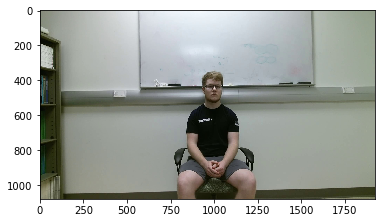

In [16]:
ex_image = imageio.imread('sample_images/000_5.jpg')
print(ex_image.shape)
plt.imshow(ex_image)